In [1]:
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math

eng = matlab.engine.start_matlab()

In [2]:
year = 2003
month = 2
day = 10
hour = 0
minute = 0
second = 0

startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day, hour+23, minute+59, second+59]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day, hour+23, minute+59, second+59)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [3]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 326 ms, sys: 116 ms, total: 442 ms
Wall time: 3.2 s


In [4]:
%%time
from collections import OrderedDict

stationsYearMagPosition = OrderedDict(OrderedDict())
stationPosition = OrderedDict()  

for x in allMatData:  
    stationsYearMagPosition[str(x[1][0])] = OrderedDict()  
    try:
        for i in range(len(x[5][0])):
            stationPosition[x[5][0][i]] = x[9][0][i], x[10][0][i]
            stationsYearMagPosition[str(x[1][0])] = stationPosition.copy()
    except:
        print("no value")

CPU times: user 126 ms, sys: 7.23 ms, total: 133 ms
Wall time: 131 ms


In [69]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
#     x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
    y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
#     indicator = gaussian(ratio, 1, 0)
    return np.round(x2,10)

In [70]:
def AbsoluteValue(array):
    return (abs(max(array))+abs(min(array)))/2
def gaussian(x, a, b, c):
    return a*math.exp(-np.power((x-b),2)/(2*np.power(c,2)))


# x = np.linspace(-20, 20, 1000)
# fig= plt.figure(figsize=(20,8))
# axes= fig.add_axes([0.8,0.8,0.8,0.8])
# gauss = np.vectorize(gaussian)
# print(gaussian(15, 1, 0, AbsoluteValue(x)))
# axes.plot(x, gauss(x, 1, 0, AbsoluteValue(x)))
# plt.show()

In [71]:
%%time
stationIndicatorVariation.clear()
timeBetweenValues = 8
dataResolution = 0
dataBeforeNormalizaton = np.array([])

if 360%(1440/timeBetweenValues)==0:
    dataResolution = 360/(1440/timeBetweenValues)
    
    for st in allStationCodes:
        delta = endDate-startDate
        totalMinutes = (delta.total_seconds()+1)/60
        for i in range(0, np.int16(totalMinutes+1), timeBetweenValues):
            try:
                update = datetime.timedelta(minutes=i)
                currentDate = startDate+update
                stationIndicatorVariation[st].append(float(IndicatorCalculation(stationsOut.get(st), i, currentDate)))
            except:
                None
            
else:
    print("!ERROR! -- Your timeBetweenValues must be a multiple of the chosen time delta's amount of minutes -- !ERROR!")
    sys.exit



CPU times: user 22.1 s, sys: 1.05 s, total: 23.2 s
Wall time: 34 s


In [72]:
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
normalizedStationIndicatorVariation = defaultdict(list)
normalized01StationIndicatorVariation = defaultdict(list)
imp = Imputer(strategy="mean", axis=0)
scale = MinMaxScaler()

def NormalizeDataGauss():
    for st in allStationCodes:
        for i in range(0, len(stationIndicatorVariation[st])):
            normalizedStationIndicatorVariation[st].append(gaussian(stationIndicatorVariation[st][i], 1, 0, AbsoluteValue(stationIndicatorVariation[st])))

def NormalizeData01():
    for st in allStationCodes:
        shapedValues = np.array(stationIndicatorVariation[st])
        if shapedValues.shape[0] != 0:
            if not math.isnan(stationIndicatorVariation[st][0]):
                a = imp.fit_transform(shapedValues.reshape(shapedValues.shape[0],1))
                transform = scale.fit_transform(a)
                normalized01StationIndicatorVariation[st].append(transform.reshape(transform.shape[0]))    
                

def ManuallyNormalizeData01():

    max_values = np.array([])
    min_values = np.array([])
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
    
    totalMax = max(max_values)
    totalMin = min(min_values)
    
    for st in allStationCodes:
        for i in range(0, len(stationIndicatorVariation[st])):
            normalized01StationIndicatorVariation[st].append((stationIndicatorVariation[st][i] - totalMin) / (totalMax - totalMin))



# NormalizeDataGauss()
# NormalizeData01()
ManuallyNormalizeData01()

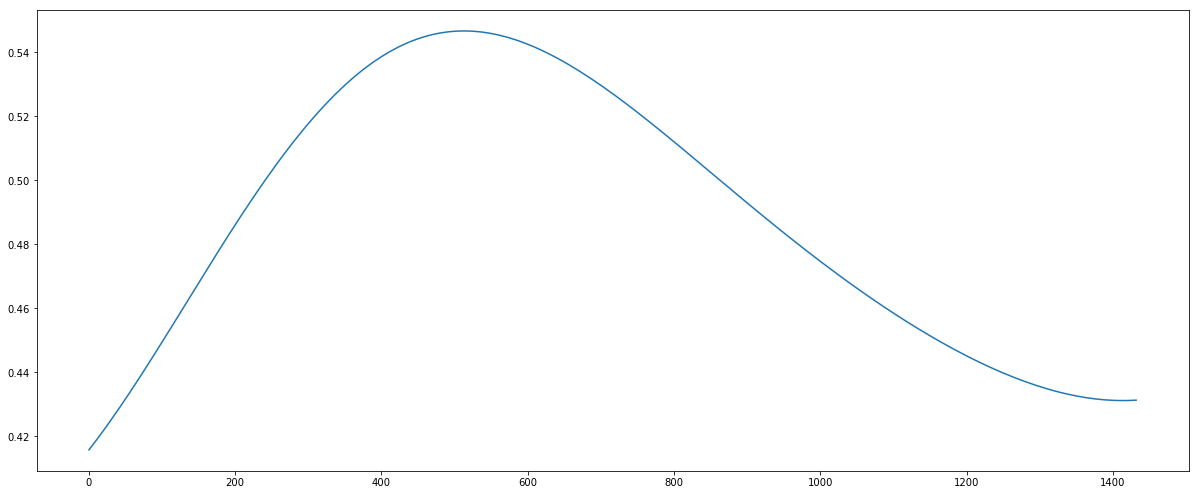

In [74]:
y = np.array(normalized01StationIndicatorVariation["tam"])
x = np.arange(0, 1440, timeBetweenValues)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

In [75]:
def AdaptDimensions(vector):
    outputVector=np.array([])
    shift=360/vector.shape[0]
    for y in range(0, vector.shape[0]):
        for i in range(0, shift):
            outputVector = np.append(outputVector, vector[y])
    return outputVector

In [78]:
indicatorVariationArray = np.full((180, 360), np.nan)

def makeIndicatorVariationArray(normalizedGauss, normalizedScaler):
    for st in allStationCodes:
        for i in range(-90, 90):
            if not isinstance(stationsOut[st], matlab.mlarray.double):
                try:
                    if i == np.round(np.int16(stationsOut[st].get("latgeo")),0):
                        if normalizedScaler: 
                            indicatorVariationArray[i+90]=AdaptDimensions(np.array(normalized01StationIndicatorVariation[st]))
                        elif normalizedGauss: 
                            indicatorVariationArray[i+90]=AdaptDimensions(np.array(normalizedStationIndicatorVariation[st]))
                        else: indicatorVariationArray[i+90]=AdaptDimensions(np.array(stationIndicatorVariation[st]))
                    else:
                        None
                except:
                    None
                    
makeIndicatorVariationArray(False,True)

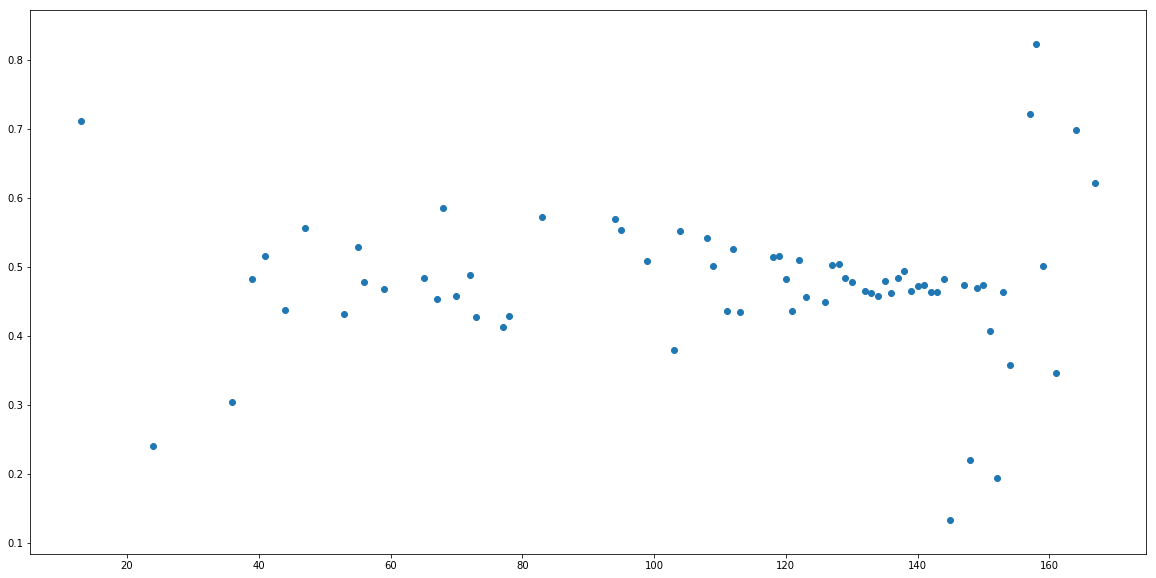

In [79]:
indicatorLatVariation = np.array([])
xLat =  np.array([])
for i in range(0, indicatorVariationArray.shape[0]):
    indicatorLatVariation = np.append(indicatorLatVariation, indicatorVariationArray[i][180])
    
xLat = np.arange(0, 180, 1).reshape(180, 1)
fig, ax1 = plt.subplots()

ax1.scatter(xLat, indicatorLatVariation.reshape(indicatorLatVariation.shape[0], 1))
fig.set_size_inches(20,10)

In [86]:
def PredictIndicatorForOneLatitude(wantedLatitude):
    timePrediction = np.full((360), np.inf)
    for i in range(0, 360, dataResolution):
        result = GetIndicatorLongPrediction(wantedLatitude,i)
        for y in range(i,i+dataResolution):
            timePrediction[y] = result
    return timePrediction

def AddTimePredictionToGlobal(prediction, latitude):
    indicatorVariationArray[latitude] = prediction
    
# AddTimePredictionToGlobal(PredictIndicatorForOneLatitude(90), 90)

In [89]:
ReconstructedArray = np.empty_like(indicatorVariationArrayIncreasedResolution)

def PredictIndicatorForAllLatitudes(baseArray):
    params = ParametersTuning(baseArray,180)
    for i in range(0,baseArray.shape[0]):
        specificLatitudeTimePrediction = np.full((360), np.inf)
        if math.isinf(baseArray[i][0]) or math.isnan(baseArray[i][0]):
            for y in range(0,baseArray.shape[1],dataResolution):  
                print("Latitude index {} predicted out of {} in total, with hyper parameters {}".format(i, baseArray.shape[0],params))
                clear_output(wait=True)
                result = GetIndicatorLongPrediction(i,y,params,baseArray)
                for t in range(y,y+dataResolution):
                    specificLatitudeTimePrediction[t] = result
            ReconstructedArray[i] = specificLatitudeTimePrediction
        else:
            ReconstructedArray[i] = baseArray[i]

PredictIndicatorForAllLatitudes(indicatorVariationArrayIncreasedResolution)

Latitude index 719 predicted out of 720 in total, with hyper parameters {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}


In [92]:
# np.savetxt("ReconstructedArray720x1.csv", ReconstructedArray, delimiter=",")
ReconstructedArray = np.empty_like(indicatorVariationArrayIncreasedResolution)

In [86]:
def IncreaseLatitudeResolution(array,resolutionValue):
    insertionArray = np.full((array.shape[0]*resolutionValue,360),np.nan)
    y=0
    for i in range(0, array.shape[0]):
        insertionArray[y] = array[i]
        y+=resolutionValue
    return insertionArray

indicatorVariationArrayIncreasedResolution = IncreaseLatitudeResolution(indicatorVariationArray,4)

In [63]:
def ZoomOnArray(zoomedArrayValueReference, latitudesAround):
    yResize = [zoomedArrayValueReference-latitudesAround, zoomedArrayValueReference+latitudesAround]
    plt.xlim(0,1440)
    plt.ylim(yResize[0], yResize[1])
    
    maxValues = np.array([])
    minValues = np.array([])
    
    if latitudesAround != 0:
        for i in range(((yResize[0])+90)*4, ((yResize[1])+90)*4):
            maxValues = np.append(maxValues, max(ReconstructedArray[i]))
            minValues = np.append(minValues, min(ReconstructedArray[i]))

        plt.clim(min(minValues), max(maxValues))
    else:
        plt.clim(min(ReconstructedArray[(zoomedArrayValueReference+90)*4]), max(ReconstructedArray[(zoomedArrayValueReference+90)*4]))

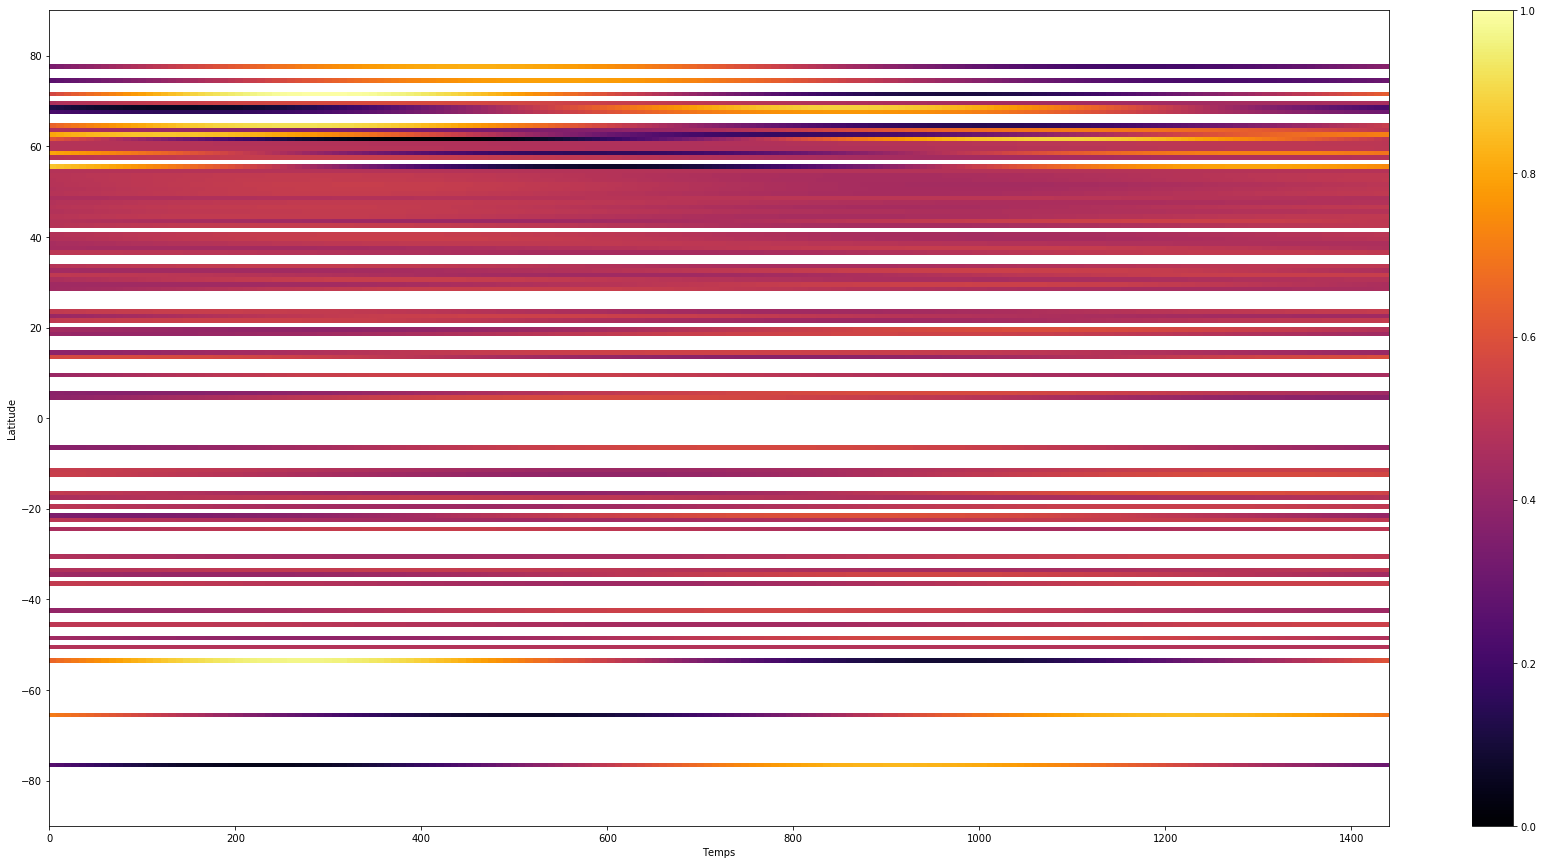

In [100]:
fig= plt.figure(figsize=(30,15))
plt.imshow(indicatorVariationArray, origin='lower', cmap=plt.get_cmap("inferno"), aspect='auto', extent=[0,1440,-90,90])
#indicatorVariationArray, ReconstructedArray, indicatorVariationArrayIncreasedResolution
plt.xlabel("Temps")
plt.ylabel("Latitude")
plt.colorbar()
# ZoomOnArray(60,5)
plt.savefig('OutputMatrix.png')
plt.show()

In [82]:
def GetIndicatorLongPrediction(latitude, longitude, params, baseArray):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][longitude])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)
    x,y = RemoveInfNan(x, y)
    return SupportVectorRegression(x,y,params).predict(latitude)

In [83]:
from sklearn.svm import SVR

def SupportVectorRegression(latValues, indicatorValues,params):
    svr_rbf = SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
    SVRmodel = svr_rbf.fit(latValues, indicatorValues)
    
    return SVRmodel


def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [84]:
# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.scatter(X_train, y_train)
# ax2.scatter(X_test, y_test)
# fig.set_size_inches(15,5)

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def ParametersTuning(baseArray,long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)

    x, y = RemoveInfNan(x, y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.scatter(X_train, y_train)
#     ax2.scatter(X_test, y_test)
#     fig.set_size_inches(15,5)
    
    parameters = {'kernel':['rbf'], 'gamma': [1e-4, 1e-3, 1e-2, 0.01],'C': [1, 10, 50, 100]}
    svr = GridSearchCV(SVR(), parameters)
    svr.fit(X_train, y_train)
    print('score',svr.score(X_test, y_test))
    modelBestParams = svr.best_params_
    print ("Parameters tuning finished, best params: {}".format(modelBestParams))
    return modelBestParams

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  from ipykernel import kernelapp as app
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


('score', 0.7860480585200227)
['kernel', 'C', 'gamma']
Parameters tuning finished, best params: {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}


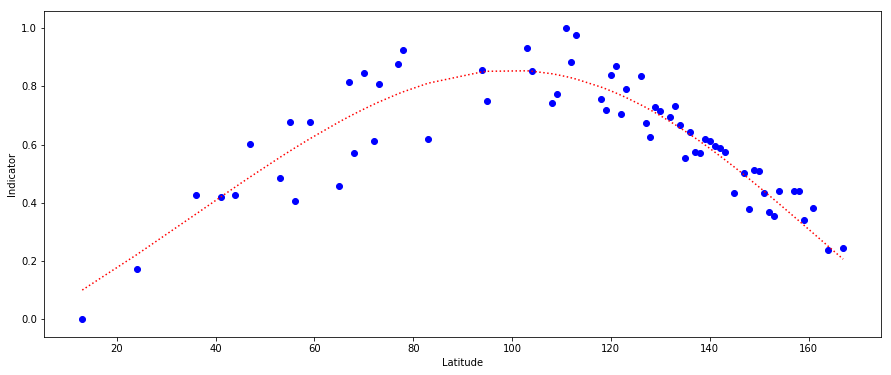

In [23]:
def printModelFitForGivenLong(baseArray, long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)
    

    x, y = RemoveInfNan(x, y)
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(y.shape[0], 1))
    
    
    plt.figure(figsize=(15,6))
    plt.xlabel("Latitude")
    plt.ylabel("Indicator")
    plt.scatter(x, y, c = 'blue')
    plt.plot(x, SupportVectorRegression(x,y,ParametersTuning(baseArray,long)).predict(x), "r:")
    plt.show()
    
printModelFitForGivenLong(indicatorVariationArray, 180)